# 4.3 データセットをトレーニングセットとテストデータセットに分割する。
- wineという新しいデータセットに対して、前処理を行ったあと、次元数を減らすための様々な手法を見ていく。

In [1]:
import pandas as pd
import numpy as np
#windデータセットを読み込む
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
#列名を設定
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids',
             'Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
#クラスラベルの表示
print('Class labels',np.unique(df_wine['Class label']))
#wineデータセットの先頭5行表示
df_wine.head()

('Class labels', array([1, 2, 3]))


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- サンプルはクラス1，2，3のいずれかに属する。
- テストデータセットとトレーニングデータセットに分割する。

In [2]:
from sklearn.cross_validation import train_test_split
# 特徴量とクラスラベルを別々に抽出
X,y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
#トレーニングデータセットとテストデータに分割
#全体の30%をテストデータにする
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

- テストとトレーニングで最もよく使われる比率は、60：40、70：30、80：20がある。データセットが大きい場合は、トレーニングデータセットとテストデータセットを90：10または、99：1の比率で分割するのも一般的。

# 4.4 特徴量の尺度を揃える
- 特徴量のスケーリング極めて重要なステップである。
- 機械学習と最適化のアルゴリズムの大半は、特徴量の尺度が同じである場合にはるかにうまく動作する。
- 尺度が異なる特徴量同士で学習し重み係数を計算した場合、尺度の値域が大きい特徴量の寄与が支配的になる。
- 尺度を揃える一般的な手法としては正規化と標準化の２つがある。
- 正規化は特徴量を[0,1]の範囲にスケーリングし直すことを意味する。
$$x_{norm}^{(i)} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}$$

In [3]:
#min-maxスケーリング（正規化）
from sklearn.preprocessing import MinMaxScaler
#min-maxスケーリングのインスタンスを作成
mms = MinMaxScaler()
#トレーニングデータをスケーリング
X_train_norm = mms.fit_transform(X_train)
#テストデータをスケーリング
X_test_norm = mms.transform(X_test)

- min-maxスケーリングは有界区間の値が必要である場合に役立つが、多くの機械学習のアルゴリズムには標準化の方が実用的かもしれない。
- 多くの線形モデルが重みを0または、0に近い小さな乱数に初期化するからだ。（？？？）
- 特徴量の列は正規分布に従うため、重みを学習しやすくなる。（？？？）
- 標準化では、外れ値に関する有益な情報が維持される。
- min-max方よりも、外れ値から受ける影響が少なくなる。
$$x_{std}^{(i)} = \frac{x^{(i)} - \mu_{x}}{\sigma_{x}}$$

In [4]:
from sklearn.preprocessing import StandardScaler
#標準化のインスタンス作成（平均=0、標準偏差=1に変換）
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 4.5 有益な特徴量の選択
- モデルの汎化誤差を減らすための一般的な方法は以下のとおりである。
①さらに多くのトレーニングデータを集める。
②正則化を通じて複雑さにペナルティを科す
③パラメータの数が少ない、より単純なモデルを選択する
④データの次元の数を減らす
- ここでは正則化と、特徴量の選択による次元削減を行うことで、過学習を減らす一般的な方法について見る

# 4.5.1 L1正則化による疎な解
- モデルの複雑さは大きなペナルティを科すことによって低減される。
- L2正則化と対照的にL1正則化によって返されるのは疎な特徴ベクトルであり、ほとんどの重みは0となる。
- 要素のほとんどが0といった疎性が役に立つのは無関係な特徴量の個数が多い高次元のデータセットがある。
$$L2:\| \vec{w} \|^{2}_{2} = \sum^{m}_{j=1}w^{2}_{j}$$
$$L1:\| \vec{w} \|_{1} = \sum^{m}_{j=1} \|w_{j}\|$$
- 正則化の目標はペナルティを受けないコスト関数とペナルティ項の和を最小化にすることである。
- L1正則化における最適化条件（コスト関数の楕円とL1のひし形の境界線の交点）は軸上にある可能性が高く、その条件は疎性を助長する。

In [5]:
from sklearn.linear_model import LogisticRegression
# L1正則化ロジスティック回帰のインスタンスを生成
LogisticRegression(penalty='l1')
#L1正則化ロジスティック回帰のインスタンスを生成（逆正則化パラメータC=0.1）
lr = LogisticRegression(penalty='l1',C=0.1)
#トレーニングデータに適合
lr.fit(X_train_std,y_train)
#トレーニングデータに対する正解率の表示
print('Training accuracy:',lr.score(X_test_std,y_test))

('Training accuracy:', 0.98148148148148151)


In [6]:
#切片の表示
lr.intercept_

array([-0.38385587, -0.15812762, -0.70047196])

In [7]:
#重み係数の表示
lr.coef_

array([[ 0.28023147,  0.        ,  0.        , -0.02794364,  0.        ,
         0.        ,  0.70999633,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23615615],
       [-0.64369236, -0.06891481, -0.05715499,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.9271545 ,
         0.0598489 ,  0.        , -0.37107967],
       [ 0.        ,  0.06153639,  0.        ,  0.        ,  0.        ,
         0.        , -0.63547429,  0.        ,  0.        ,  0.49784521,
        -0.35842121, -0.57169139,  0.        ]])

- 重みベクトルは、0ではないエントリがほんの僅かで、疎であることがわかる。

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


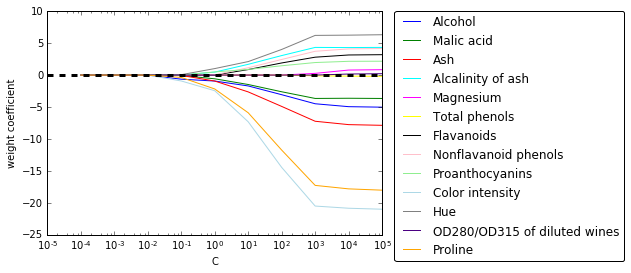

In [8]:
#正則化パスのグラフ化
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(111)
#各係数の色リスト
colors = ['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue',
         'gray','indigo','orange']
#空のリストを作成（重み係数、逆正則化パラメータ）
weights,params = [],[]
#逆生息化パラメータの値ごとに処理
for c in np.arange(-4,6):
    lr = LogisticRegression(penalty='l1',C=10**c,random_state=0)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

#重み係数をNumpy配列に変換
weights = np.array(weights)
#各重み係数をプロット
for column,color in zip(range(weights.shape[1]),colors):
    #横軸を正則化パラメータ、縦軸を重み係数とした折れ線グラフ
    plt.plot(params,weights[:,column],label=df_wine.columns[column+1],color=color)

#y=0に黒い破線を引く
plt.axhline(0,color='black',linestyle='--',linewidth=3)
#横軸の範囲の設定
plt.xlim([10**(-5),10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
#横軸を対数スケール
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',bbox_to_anchor=(1.38,1.03),ncol=1,fancybox=True)
plt.show()

# 逐次特徴選択アルゴリズム
- 特徴選択による次元削減は、モデルの複雑さを低減し、過学習を回避するもう１つの方法である。この方法は正則化されていない場合に役立つ。
- 次元削減法は主に特徴選択と特等抽出の２つのカテゴリに分かれている。
- 特徴選択では、元の特徴量の一部を選択する。
- 特徴抽出では、新しい特徴部分空間を生成するために特徴量の集合から情報を抽出する。
- 逐次特徴選択のアルゴリズムは、貪欲探索アルゴリズムの一種である。d次元の特徴空間をk次元の特徴空間に削減するために使用される。
- 特徴選択のアルゴリズムには2つの目的がある。
- 1つは、問題に最も関連がある特徴量の部分集合を自動的に選択することにより、計算効率を改善することである。
- もう１つは無関係の特徴量やノイズを取り除くことで、モデルの汎化誤差を削減することである。正則化をサポートしていないアルゴリズムに役立つ
- 逐次後退選択（SBS）は、元々の特徴空間の次元を減らすことが目的で、分類器の性能の低下を最小限に抑えた上で計算効率を改善する。
- SBSは新しい特徴部分空間に目的の個数の特徴量が含まれるまで、特徴量を逐次的に削除していく。
- 直感的には各段階で性能の低下が最も少ない特徴量を削除する。

①アルゴリズムを$k=d$で初期化する。dは全体の特徴空間$X_{d}$の次元数を表す。

②$J$の評価最大化する特徴量$x_{-}$を決定する。$x \in X_{k}$
$$x^{-} = argmaxJ(X_{k}-x)$$
③特徴量の集合から特徴量$x^{-}$を削除する
$$X_{k-1} := X_{k}-x^{-} ; k:=k-1$$
④kが目的とする特徴量の個数に等しくなれば終了する。そうでなければ、スッテプ2に戻る。

In [15]:
#SBSアルゴリズム
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    '''
    逐次後退選択を実行するクラス
    '''
    def __init__(self,estimator,k_features,scoring=accuracy_score,test_size=0.25,random_state=1):
        self.scoring = scoring              #特徴量を評価する指標
        self.estimator = clone(estimator)   #推定器
        self.k_features = k_features        #選択する特徴量の個数
        self.test_size = test_size          #テストデータの割合
        self.random_state = random_state    #乱数種を固定する
        
    def fit(self,X,y):
        # トレーニングデータとテストデータに分割
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        # すべての特徴量の個数、列インデックス
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # すべての特徴量を用いてスコアを算出
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        # スコアを格納
        self.scores_ = [score]
        # 指定した特徴量の個数になるまで処理を反復
        while dim > self.k_features:
            # 空のリストを生成（スコア、列インデックス）
            scores = []
            subsets = []
            
            # 特徴量の部分集合を表す列インデックスの組み合わせ毎に処理を反復
            for p in combinations(self.indices_,r=dim-1):
                #スコアを算出して格納
                score = self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                #特徴量の部分集合を表す列インデックスのリストを格納
                subsets.append(p)
            # 最良のスコアのインデックスを抽出
            best = np.argmax(scores)
            # 最良のスコアとなる列インデックスを抽出して格納
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            # 特徴量の個数を１つだけ減らして次のステップへ
            dim -= 1
            
            #スコアを格納
            self.scores_.append(scores[best])
        #最後に格納したスコア
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:,self,indices_]
    
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        # 指定された列番号indicesの特徴量を抽出してモデルに適合
        self.estimator.fit(X_train[:,indices],y_train)
        # テストデータを用いてクラスラベルを予測
        y_pred = self.estimator.predict(X_test[:,indices])
        # 真のクラスラベルと予測値を用いてクラスを算出
        score = self.scoring(y_test,y_pred)
        return score

In [16]:
#SBSを適用
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
# k近傍分類器のインスタンスを生成（近傍点数=2）
knn = KNeighborsClassifier(n_neighbors=2)
#逐次後退選択のインスタンスを生成（特徴量の個数が１になるまで特徴量を選択）
sbs = SBS(knn,k_features=1)
# 逐次後退選択を実行
sbs.fit(X_train_std,y_train)

<__main__.SBS instance at 0x7fab5f9a5710>

- SBS実装では、fit関数の中ですでにデータセットをテストデータセットとトレーニングデータセットに分割している。
- それでもトレーニングデータ・セットを入力することにより、元のテストデータ・セットがトレーニングデータセットの一部になるのを防いでいる。

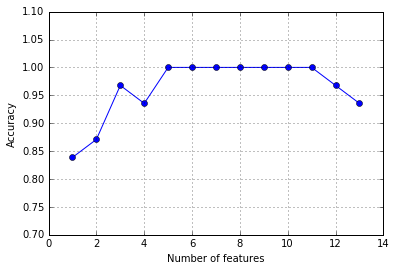

In [17]:
# 近傍点の個数リスト（13，12，11，・・・1）
k_feat = [len(k) for k in sbs.subsets_]
# 横軸を近傍点の個数、縦軸をスコアと下折れ線グラフのプロット
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

- 特徴量の個数を減らしたため、検証データセットに対するKNN分類器の正解率が改善されている。
- k={5,6,7,8,9,10,11}のとき、分類器が100%の正解率を達成したこともわかる。

In [19]:
#100%を達成した5つの特徴量
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index([u'Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


In [21]:
#元のデータセットでKNN分類器の性能評価
knn.fit(X_train_std,y_train)
#トレーニングの正解率を出力
print('Training accuracy:',knn.score(X_train_std,y_train))
#テストの正解率を出力
print('Test accuracy:',knn.score(X_test_std,y_test))

('Training accuracy:', 0.9838709677419355)
('Test accuracy:', 0.94444444444444442)


- 特徴量全体を使用した場合、トレーニングデータ・セットで最大98.4%、テストデータ・セットで94.4%と若干低く、過学習の兆候が見られる。

In [23]:
#5個の特徴量を用いてモデルに適合
knn.fit(X_train_std[:,k5],y_train)
# トレーニングデータの正解率を出力
print('Training accuracy:',knn.score(X_train_std[:,k5],y_train))
#テストの正解率を出力
print('Test acuracy:',knn.score(X_test_std[:,k5],y_test))

('Training accuracy:', 0.95967741935483875)
('Test acuracy:', 0.96296296296296291)
